In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [3]:
df = pd.read_excel('data.xlsx', engine="openpyxl")
df.head()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171


In [4]:
df.nunique()

ID              6000
Carat Weight     196
Cut                5
Color              6
Clarity            7
Polish             4
Symmetry           4
Report             2
Price           4821
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6000 non-null   int64  
 1   Carat Weight  6000 non-null   float64
 2   Cut           6000 non-null   object 
 3   Color         6000 non-null   object 
 4   Clarity       6000 non-null   object 
 5   Polish        6000 non-null   object 
 6   Symmetry      6000 non-null   object 
 7   Report        6000 non-null   object 
 8   Price         6000 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 422.0+ KB


In [6]:
df.describe()

,ID,Carat Weight,Price
count,6000.000000,6000.000000,6000.000000
mean,3000.500000,1.334520,11791.579333
std,1732.195139,0.475696,10184.350051
min,1.000000,0.750000,2184.000000
25%,1500.750000,1.000000,5150.500000
50%,3000.500000,1.130000,7857.000000
75%,4500.250000,1.590000,15036.500000
max,6000.000000,2.910000,101561.000000


In [7]:
cat_features = df.select_dtypes('object').columns
cat_features

Index(['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report'], dtype='object')

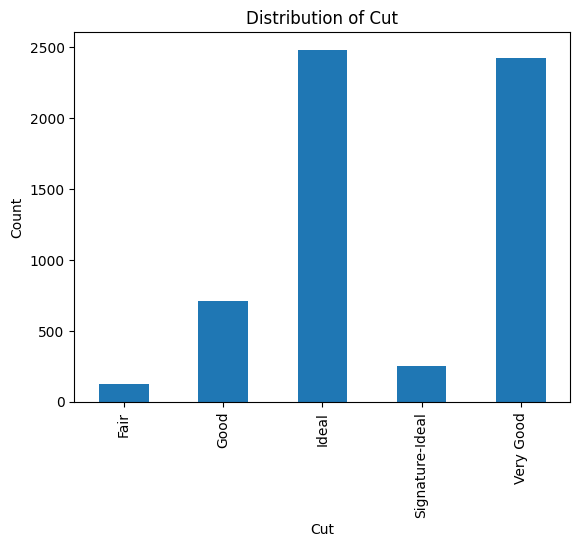

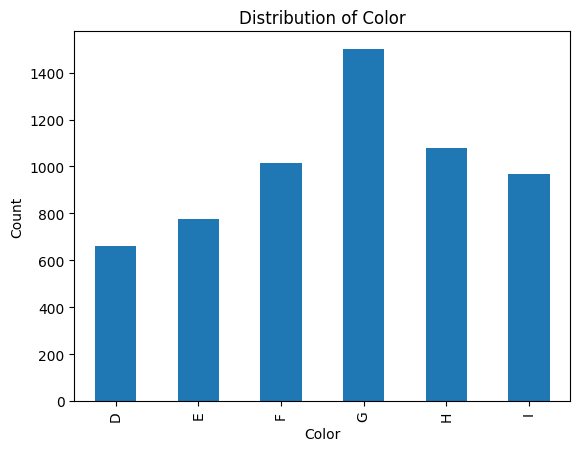

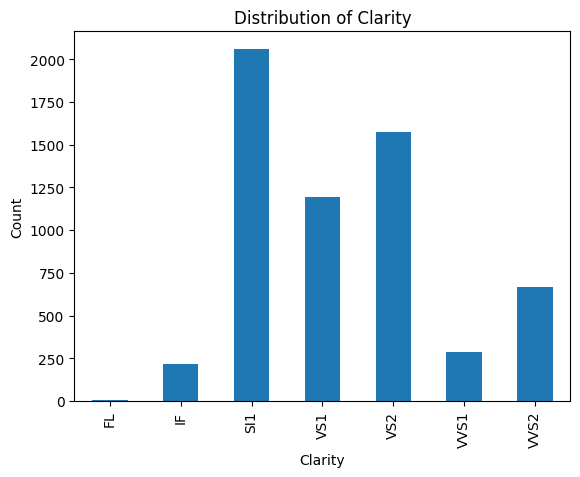

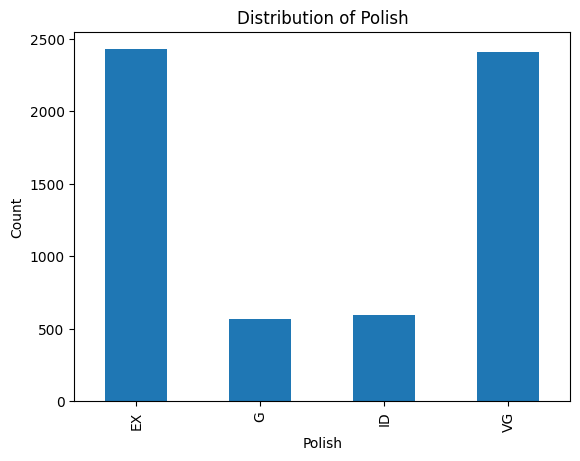

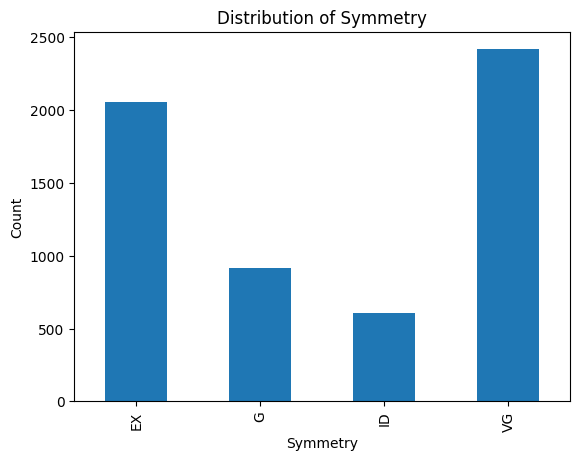

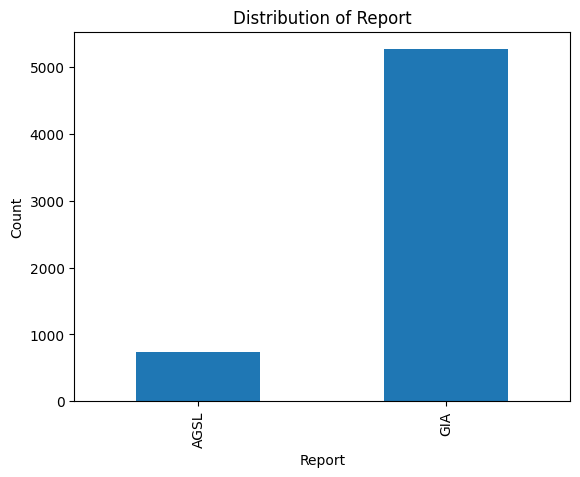

In [8]:
for col in cat_features:
    plt.figure()
    df[col].value_counts().sort_index().plot(kind="bar")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [9]:
df['Symmetry'].unique()

array(['EX', 'ID', 'VG', 'G'], dtype=object)

In [10]:
from sklearn.preprocessing import OrdinalEncoder
cut_order = ["Fair", "Good", "Very Good", "Ideal", 'Signature-Ideal']
color_order = ["Z","K","J", "I", "H", "G", "F", "E", "D"]
clarity_order = ['SI1',  'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']
polish_order = ['G', 'VG', 'EX', 'ID']
symmetry_order = [ 'G', 'VG','EX', 'ID']
report_order = ['AGSL', 'GIA']
oe = OrdinalEncoder(categories=[
            cut_order,
            color_order,
            clarity_order,
            polish_order,
            symmetry_order,
            report_order
        ])

df_encoded = df.copy()

df_encoded[cat_features] = oe.fit_transform(df_encoded[cat_features])

In [11]:
df_encoded.head()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,3.0,4.0,0.0,1.0,2.0,1.0,5169
1,2,0.83,3.0,4.0,2.0,3.0,3.0,0.0,3470
2,3,0.85,3.0,4.0,0.0,2.0,2.0,1.0,3183
3,4,0.91,3.0,7.0,0.0,1.0,1.0,1.0,4370
4,5,0.83,3.0,5.0,0.0,2.0,2.0,1.0,3171


In [12]:
df.head()

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171


In [13]:
X = df_encoded.drop(['ID', 'Price'], axis = 1)
y = df_encoded['Price']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred = rf_model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2 Score: 0.9814608371589494
MAE: 677.2587086034265


In [17]:
df['PredictedValue'] = rf_model.predict(X)
df["Residual"] = df["Price"] - df["PredictedValue"]
df["PricePerCarat"] = df["Price"] / df["Carat Weight"]

In [18]:
best_variants = df.copy()


In [19]:
best_variants["score"] = (

    (best_variants["Residual"] < 0).astype(int) * 5 +


    best_variants["Cut"].isin(["Ideal", "Signature-Ideal"]).astype(int) * 4 +
    best_variants["Cut"].isin(["Very Good"]).astype(int) * 2 +


    best_variants["Color"].isin(["G", "H", "I", "GH"]).astype(int) * 3 +
    best_variants["Color"].isin(["F"]).astype(int) * 2 +
    best_variants["Color"].isin(["D", "E"]).astype(int) * 1 +

    best_variants["Clarity"].isin(["VS1", "VS2"]).astype(int) * 3 +
    best_variants["Clarity"].isin(["VVS1", "VVS2"]).astype(int) * 2 +
    best_variants["Clarity"].isin(["SI1"]).astype(int) * 1 +

    (best_variants["PricePerCarat"] < (df['Price'].sum() / df['Carat Weight'].sum())).astype(int) * 2 +

    best_variants["Polish"].isin(["VG", "EX", "ID"]).astype(int) * 1 +
    best_variants["Symmetry"].isin(["VG", "EX", "ID"]).astype(int) * 1 +
    best_variants["Report"].isin(["GIA", "AGSL"]).astype(int) * 1
)

In [20]:
top_5_diamonds = best_variants.sort_values(by="score", ascending=False).head(5)
top_5_diamonds

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,PredictedValue,Residual,PricePerCarat,score
5938,5939,1.01,Ideal,I,VS1,EX,VG,GIA,5022,5125.578874,-103.578874,4972.277228,20
573,574,1.12,Signature-Ideal,G,VS2,EX,EX,GIA,8189,8363.657051,-174.657051,7311.607143,20
2809,2810,1.07,Ideal,G,VS1,ID,ID,AGSL,7161,7541.147438,-380.147438,6692.523364,20
5200,5201,0.94,Ideal,H,VS2,VG,VG,GIA,4358,4556.849070,-198.849070,4636.170213,20
5205,5206,1.07,Ideal,H,VS2,EX,EX,GIA,6114,6249.380406,-135.380406,5714.018692,20


In [21]:
final_df = top_5_diamonds.drop(['PredictedValue', 'Residual', 'PricePerCarat', 'score'], axis = 1)

In [22]:
final_df.to_csv('top5diamonds.csv', index=False)

In [23]:
pd.read_csv('top5diamonds.csv')

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,5939,1.01,Ideal,I,VS1,EX,VG,GIA,5022
1,574,1.12,Signature-Ideal,G,VS2,EX,EX,GIA,8189
2,2810,1.07,Ideal,G,VS1,ID,ID,AGSL,7161
3,5201,0.94,Ideal,H,VS2,VG,VG,GIA,4358
4,5206,1.07,Ideal,H,VS2,EX,EX,GIA,6114
